# Dominant colors in images

Kmeans clustering can be used for feature identification in satellite imgaes.

![image-9](image-9.png)


### Tools to find dominant colors
- Convert image to pixels: `matplotlib.image.imread`
- Display colors of cluster centers: `matplotlib.pyplot.imshow`

In [45]:
# converting imagr to RGB matrix
import matplotlib.image as img
image = img.imread('./fantastic-seascape-with-ripples (2).jpg')
image.shape

(333, 500, 3)

In [46]:
image

array([[[154, 189, 243],
        [154, 189, 243],
        [154, 189, 243],
        ...,
        [190, 214, 250],
        [190, 214, 250],
        [190, 214, 250]],

       [[154, 189, 243],
        [154, 189, 243],
        [154, 189, 243],
        ...,
        [191, 215, 251],
        [191, 215, 251],
        [191, 215, 251]],

       [[154, 189, 243],
        [155, 190, 244],
        [155, 190, 244],
        ...,
        [191, 215, 251],
        [191, 215, 251],
        [191, 215, 251]],

       ...,

       [[ 49,  93, 132],
        [ 48,  93, 132],
        [ 45,  90, 131],
        ...,
        [135, 174, 213],
        [137, 176, 215],
        [136, 175, 214]],

       [[ 42,  86, 125],
        [ 42,  86, 125],
        [ 39,  84, 125],
        ...,
        [149, 188, 227],
        [149, 188, 227],
        [146, 185, 224]],

       [[ 53,  96, 138],
        [ 57, 100, 142],
        [ 57, 102, 144],
        ...,
        [148, 186, 223],
        [148, 186, 223],
        [145, 183, 220]]

In [47]:
image[0]

array([[154, 189, 243],
       [154, 189, 243],
       [154, 189, 243],
       ...,
       [190, 214, 250],
       [190, 214, 250],
       [190, 214, 250]], dtype=uint8)

In [48]:
image[0].shape

(500, 3)

In [49]:
# list of r,g,b in each pixel of the image
r = []
g = []
b = []

for row in image:
    for pixel in row:
        # A pixel contains RGB values
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

In [50]:
import pandas as pd

# Dataframe with RGB values
pixels = pd.DataFrame({'red':r,
                      'green':g,
                      'blue':b})
pixels.head()

,red,green,blue
0,154,189,243
1,154,189,243
2,154,189,243
3,154,189,243
4,154,189,243


In [51]:
from scipy.cluster.vq import whiten

pixels['scaled_red'] = whiten(pixels['red'])
pixels['scaled_green'] = whiten(pixels['green'])
pixels['scaled_blue'] = whiten(pixels['blue'])

pixels.head()

,red,green,blue,scaled_red,scaled_green,scaled_blue
0,154,189,243,2.249477,3.85816,6.169211
1,154,189,243,2.249477,3.85816,6.169211
2,154,189,243,2.249477,3.85816,6.169211
3,154,189,243,2.249477,3.85816,6.169211
4,154,189,243,2.249477,3.85816,6.169211


In [52]:
pixels.shape

(166500, 6)

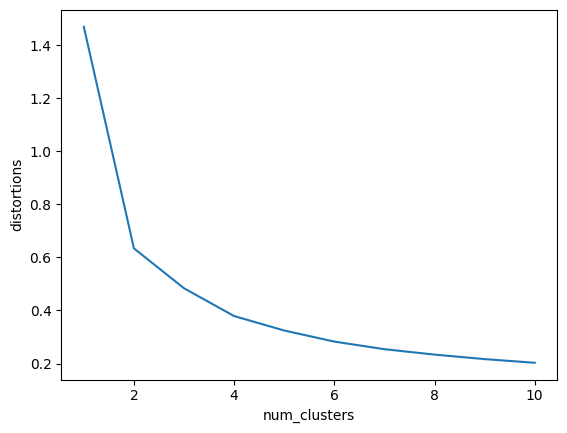

In [53]:
from scipy.cluster.vq import kmeans, vq
import seaborn as sns
import matplotlib.pyplot as plt

# elbow plot to determine number of clusters
distortions = []
num_clusters = range(1,11)

for i in num_clusters:
    cluster_centers, distortion = kmeans(pixels[['scaled_red','scaled_green','scaled_blue']],i)
    distortions.append(distortion)
    
elbow_plot = pd.DataFrame({'num_clusters':num_clusters,
                           'distortions':distortions})

sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot)
plt.show()

From elbow plot, it seems there are 3 dominant colors in the image.

In [54]:
# Find dominant colors
cluster_centers, _ = kmeans(pixels[['scaled_red','scaled_green','scaled_blue']], 3)

cluster_centers

array([[3.0031983 , 4.59433902, 6.31354128],
       [0.59460769, 2.08690381, 3.72979476],
       [1.54654814, 3.3142153 , 5.23824774]])

The cluster centers obtained are standardized RGB value. And standardized value of a variable is its actual value divided by the standard deviation.

In [55]:
colors = []

# Find Standard Deviation
r_std, g_std, b_std = pixels[['red','green','blue']].std()

# Scale actual RGB values in range of 0-1 for imshow method
for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    colors.append((
        scaled_r * r_std/255, #divide by 255 to range bet. 0-1
        scaled_g * g_std/255,
        scaled_b * b_std/255
    ))

In [56]:
#Dimensions: 3x3 (Nx3 matrix)
print(colors)

[(0.8062770448386408, 0.8826035941546633, 0.9752384465905604), (0.15963598912051988, 0.4009083347052736, 0.5761329633053246), (0.4152061048806899, 0.6366831707890492, 0.8091402847217772)]


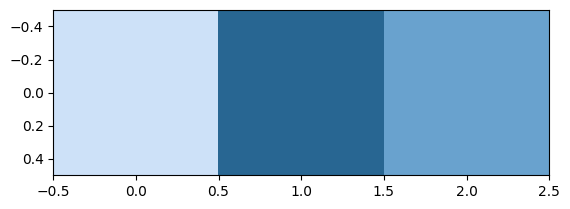

In [57]:
# Display dominant colors
# Dimensions: 1 x 3 x 3 (1 x N x 3 matrix)
plt.imshow([colors])
plt.show()

Hence, these are the dominant colors in the image.

# Document clustering
1. Clean data before processing
2. Determine the importance of the terms in a document (in TF-IDF matrix)
3. Cluster the TF-IDF matrix
4. Find top terms, documents in each cluster

In [58]:
movies_plot = pd.read_csv('datasets/movies_plot.csv')
movies_plot.head()

,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...
3,Broken Arrow,Major Vic Deakins (John Travolta) and Captain ...
4,Dolemite,Dolemite is a pimp and nightclub owner who is ...


In [59]:
plots = movies_plot['Plot'].values.tolist()

### Step1: Clean and tokenize data
- Convert text into smaller parts called tokens, clean data for processing

In [60]:
import nltk
nltk.download('punkt')

def remove_noise(text, stop_words=[]):
    tokens = nltk.word_tokenize(text) # create token for input text
    cleaned_tokens = [] 
    for token in tokens:
        if token.lower() not in stop_words and token.isalpha():
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

remove_noise('It is a sunny day, I wish to go swimming.')

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['it', 'is', 'a', 'sunny', 'day', 'i', 'wish', 'to', 'go', 'swimming']

In [61]:
print(remove_noise(plots[0]))

['cable', 'hogue', 'is', 'isolated', 'in', 'the', 'desert', 'awaiting', 'his', 'partners', 'taggart', 'and', 'bowen', 'who', 'are', 'scouting', 'for', 'water', 'the', 'two', 'plot', 'to', 'seize', 'what', 'little', 'water', 'remains', 'to', 'save', 'themselves', 'cable', 'who', 'hesitates', 'to', 'defend', 'himself', 'is', 'disarmed', 'and', 'abandoned', 'to', 'almost', 'certain', 'death', 'confronted', 'with', 'sandstorms', 'and', 'other', 'desert', 'elements', 'cable', 'bargains', 'with', 'god', 'four', 'days', 'later', 'about', 'to', 'perish', 'he', 'stumbles', 'upon', 'a', 'muddy', 'pit', 'he', 'digs', 'and', 'discovers', 'an', 'abundant', 'supply', 'of', 'water', 'after', 'discovering', 'that', 'his', 'well', 'is', 'the', 'only', 'source', 'of', 'water', 'between', 'two', 'towns', 'on', 'a', 'stagecoach', 'route', 'he', 'decides', 'to', 'live', 'there', 'and', 'build', 'a', 'business', 'cable', 'first', 'paying', 'customer', 'is', 'the', 'rev', 'joshua', 'duncan', 'sloane', 'a', '

### Step2: Document term matrix and spare matrix
![image-10](image-10.png)


In [62]:
# Import TfidfVectorizer class from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=remove_noise,max_df=0.75, min_df=0.1, max_features=50)

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

In [63]:
# tfidf_matrix --> sparse matrix
tfidf_matrix

<1000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 23980 stored elements in Compressed Sparse Row format>

### Step3: Clustering with sparse matrix
- `kmeans()` in SciPy doesnot support sparse matrices
- use `.todense()` to convert to a matrix

In [64]:
num_clusters = 2

# convert tfidf matriix to its expanded form using the .todense(), then kmeans applied to get the cluster centers
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

In [65]:
cluster_centers

array([[0.05737928, 0.10634243, 0.05148237, 0.13629622, 0.12307318,
        0.12302222, 0.06578664, 0.08053975, 0.04855044, 0.05033163,
        0.05438014, 0.13418525, 0.05237659, 0.05963471, 0.0375346 ,
        0.12568838, 0.04667883, 0.04455158, 0.10849099, 0.05734312,
        0.09599128, 0.18088528, 0.04221876, 0.09227832, 0.10959376,
        0.04117677, 0.05544909, 0.06158527, 0.07130933, 0.04967879,
        0.07326113, 0.04729273, 0.04926649, 0.09533616, 0.06115978,
        0.03824186, 0.11830034, 0.0886502 , 0.06594698, 0.1425712 ,
        0.05938238, 0.071173  , 0.08721302, 0.07402358, 0.10598967,
        0.05378482, 0.06761796, 0.07325704, 0.14257343, 0.05538804],
       [0.05750239, 0.08340842, 0.04312656, 0.09935363, 0.0594532 ,
        0.10430286, 0.04484742, 0.06451873, 0.0434229 , 0.03858643,
        0.03298443, 0.12074008, 0.04249234, 0.05445268, 0.04834965,
        0.09540643, 0.04028727, 0.04594523, 0.10956731, 0.04637961,
        0.50378068, 0.15817833, 0.05524815, 0.0

- Cluster centers: Each clulster center is a list of tfidf weights, which signifies the importance of each term in the matrix.
- Each value in the cluster center is its importance

### Step4: Top terms per cluster

In [66]:
# list of all terms
terms = tfidf_vectorizer.get_feature_names_out()
terms

array(['about', 'after', 'all', 'an', 'are', 'at', 'back', 'be', 'been',
       'before', 'being', 'but', 'can', 'father', 'finds', 'from', 'get',
       'had', 'has', 'have', 'her', 'him', 'home', 'into', 'it', 'later',
       'man', 'new', 'not', 'off', 'one', 'only', 'other', 'out', 'she',
       'tells', 'their', 'them', 'then', 'they', 'this', 'two', 'up',
       'was', 'when', 'where', 'which', 'while', 'who', 'will'],
      dtype=object)

The cluster centers has tfidf weight for each of the above terms.

In [67]:
# Create dictionary and print top terms

for i in range(num_clusters):
    # dict where terms are keys and tfidf as values
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    # sort dictionary by its values in descending order
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms)

['him', 'who', 'they', 'an', 'but', 'from', 'are', 'at', 'their', 'it', 'has', 'after', 'when', 'her', 'out', 'into', 'them', 'up', 'be', 'was', 'one', 'while', 'not', 'two', 'which', 'then', 'back', 'new', 'she', 'father', 'this', 'about', 'have', 'man', 'will', 'being', 'where', 'can', 'all', 'before', 'off', 'other', 'been', 'only', 'get', 'had', 'home', 'later', 'tells', 'finds']
['her', 'she', 'him', 'but', 'has', 'who', 'when', 'at', 'an', 'from', 'they', 'after', 'it', 'their', 'out', 'up', 'not', 'into', 'be', 'are', 'was', 'about', 'will', 'home', 'father', 'while', 'then', 'them', 'tells', 'one', 'which', 'finds', 'new', 'have', 'where', 'had', 'later', 'man', 'back', 'been', 'all', 'can', 'get', 'only', 'two', 'off', 'before', 'this', 'other', 'being']


These are the top terms on each of the clusters.

# Clustering with multiple features

In [68]:
fifa = pd.read_csv('datasets/fifa_18_sample_data.csv')
fifa.shape

(1000, 185)

In [69]:
from scipy.cluster.vq import whiten

fifa['scaled_pac'] = whiten(fifa['pac'])
fifa['scaled_dri'] = whiten(fifa['dri'])
fifa['scaled_sho'] = whiten(fifa['sho'])

fifa.shape

(1000, 188)

In [70]:
scaled_features = ['scaled_pac', 'scaled_dri', 'scaled_sho']

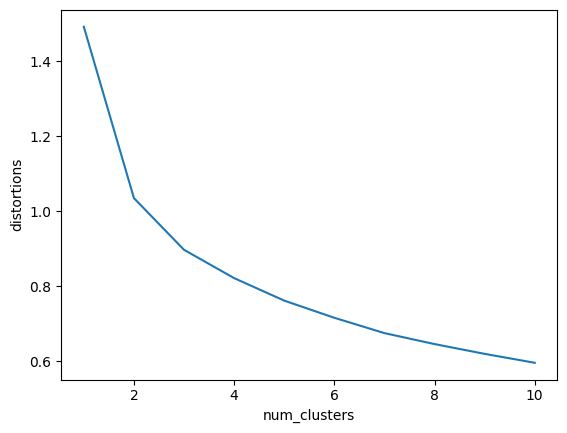

In [71]:
# elbow plot
distortions = []
num_clusters=range(1,11)

for i in num_clusters:
    cluster_centers, distortion = kmeans(fifa[['scaled_pac','scaled_dri','scaled_sho']], i)
    distortions.append(distortion)
    
elbow_plot = pd.DataFrame({'num_clusters':num_clusters,
                          'distortions':distortions})

sns.lineplot(x='num_clusters',y='distortions',data=elbow_plot)
plt.show()

In [72]:
# kmeans clustering
cluster_centers, distortion = kmeans(fifa[['scaled_pac','scaled_dri','scaled_sho']], 3)

# cluster label
fifa['cluster_labels'], _ = vq(fifa[['scaled_pac','scaled_dri','scaled_sho']], cluster_centers)

In [73]:
fifa.shape

(1000, 189)

In [74]:
# Print the size of the clusters
print(fifa.groupby('cluster_labels')['ID'].count())

# Print the mean value of wages in each cluster
print(fifa.groupby('cluster_labels')['eur_wage'].mean())

cluster_labels
0    324
1    180
2    496
Name: ID, dtype: int64
cluster_labels
0    64345.679012
1    62394.444444
2    75308.467742
Name: eur_wage, dtype: float64


# FIFA 18: what makes a complete player?
![image-11](image-11.png)


In [75]:
fifa = pd.read_csv('datasets/fifa_18_sample_data.csv')
fifa.shape

(1000, 185)

In [76]:
from scipy.cluster.vq import whiten

fifa['scaled_pac'] = whiten(fifa['pac'])
fifa['scaled_dri'] = whiten(fifa['dri'])
fifa['scaled_sho'] = whiten(fifa['sho'])
fifa['scaled_pas'] = whiten(fifa['pas'])
fifa['scaled_def'] = whiten(fifa['def'])
fifa['scaled_phy'] = whiten(fifa['phy'])

fifa.shape

(1000, 191)

In [77]:
scaled_features = ['scaled_pac',
 'scaled_sho',
 'scaled_pas',
 'scaled_dri',
 'scaled_def',
 'scaled_phy']

In [78]:
# Create centroids with kmeans for 2 clusters
cluster_centers,_ = kmeans(fifa[scaled_features], 2)

# Assign cluster labels and print cluster centers
fifa['cluster_labels'], _ = vq(fifa[scaled_features], cluster_centers)
fifa.groupby('cluster_labels')[scaled_features].mean()

,scaled_pac,scaled_sho,scaled_pas,scaled_dri,scaled_def,scaled_phy
cluster_labels,,,,,,
0,6.685415,5.424369,8.454212,8.511225,2.507692,8.339518
1,5.433011,3.660032,7.159592,6.752259,3.969287,9.208365


In [79]:
cluster_centers

array([[6.6840704 , 5.43091508, 8.45570443, 8.51497699, 2.50055169,
        8.33406578],
       [5.45404055, 3.66837898, 7.17406399, 6.76757517, 3.96670242,
        9.20987366]])

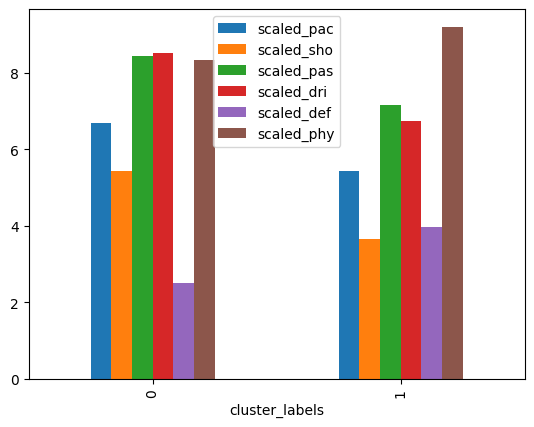

In [80]:
# Plot cluster centers to visualize clusters
fifa.groupby('cluster_labels')[scaled_features].mean().plot(legend=True, kind='bar')
plt.show()

In [81]:
fifa['cluster_labels'].unique()

array([0, 1], dtype=int32)

In [84]:
# Get the name column of first 5 players in each cluster
for cluster in fifa['cluster_labels'].unique():
    print(cluster, fifa[fifa['cluster_labels'] == cluster]['name'].values[:5])

0 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
1 ['Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng' 'D. Godín']
